# Purpose
* Verify testable implications of conditional Independence on a DAG using regression when we regress a continous outcome on categorical/binary predicators
* How to show conditional independence with a linar regression on a categorical variable?
* Do all levels of the categorical variable need to be zero?

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrix
from statsmodels.graphics.factorplots import interaction_plot

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from numpyro.infer.util import Predictive

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,jax,matplotlib,numpy,pandas,scipy,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz     : 0.11.2
jax       : 0.2.19
matplotlib: 3.4.3
numpy     : 1.20.3
pandas    : 1.3.2
scipy     : 1.6.2
numpyro   : 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 004c113c58833e40eb4e001ea74d6618fb5fb942

Git branch: master



In [5]:
proba_ = 0.28
cpt_ = jnp.array([[0.9, 0.1], [0.2, 0.8]])
mean_ = jnp.array([15.,10.])

In [6]:
def synthetic_00(proba, cpt, mean):
    A = numpyro.sample("A", dist.Bernoulli(proba))
    M = numpyro.sample("M", dist.Categorical(cpt[A]))
    D = numpyro.sample("D", dist.Normal(mean[A],1))

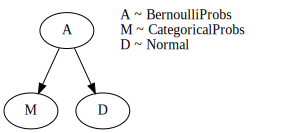

In [55]:
numpyro.render_model(
    synthetic_00,
    (proba_, cpt_, mean_),
    render_distributions=True,
)

sample: 100%|██████████| 10500/10500 [00:06<00:00, 1666.27it/s, 3 steps of size 6.37e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.28      0.45      0.00      0.00      1.00     52.96      1.01
         D     13.61      2.49     14.53      9.12     16.52     60.21      1.01
         M      0.30      0.46      0.00      0.00      1.00    115.02      1.00



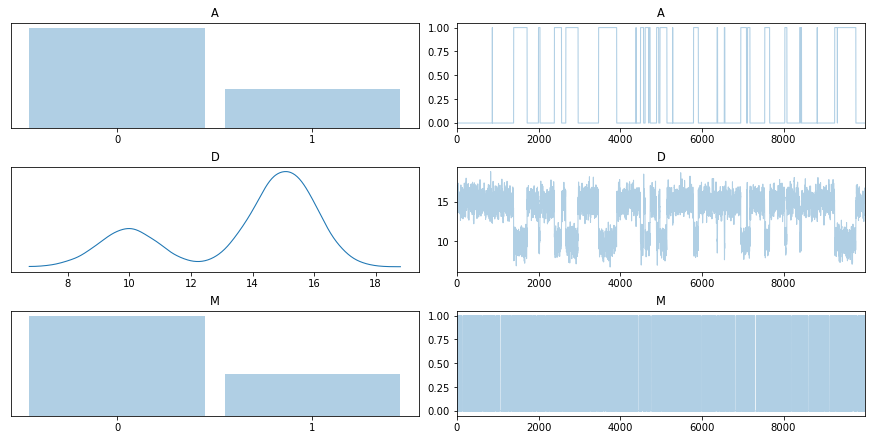

In [7]:
nuts_kernel = NUTS(synthetic_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=False)

mcmc = MCMC(
    kernel, num_warmup=500, num_samples=10_000, num_chains=1, jit_model_args=False
)
mcmc.run(
    jax.random.PRNGKey(4),
    proba_,
    cpt_,
    mean_,
)
mcmc.print_summary()
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

In [8]:
data = pd.DataFrame(mcmc.get_samples())

In [9]:
data.groupby(["A", "M"]).mean()

D
A M           
0 0  15.024989
  1  15.048301
1 0   9.892959
  1   9.956407

In [10]:
data.groupby(["A"])["D"].mean()

A
0    15.027415
1     9.943502
Name: D, dtype: float32

In [11]:
data.groupby(["M"])["D"].mean()

M
0    14.611916
1    11.244821
Name: D, dtype: float32

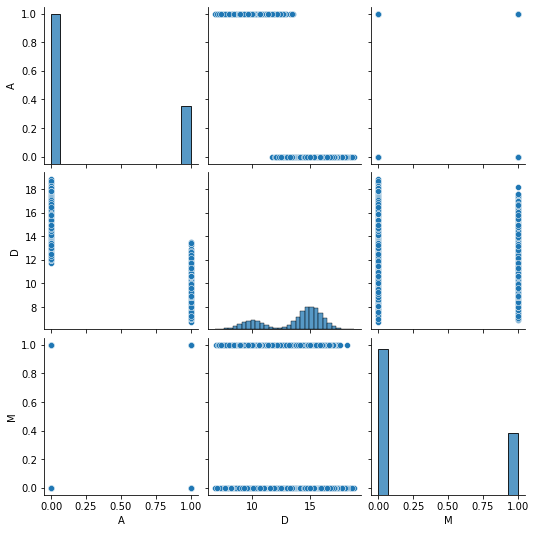

In [12]:
sns.pairplot(data)

In [13]:
data

,A,D,M
0,0,16.457668,0
1,0,17.027874,0
2,0,13.837038,0
3,0,14.401114,0
4,0,14.444053,0
...,...,...,...
9995,0,15.818029,1
9996,0,14.584752,0
9997,0,14.702188,0
9998,0,14.990218,0


In [27]:
data[["A","M"]].drop_duplicates()

,A,M
0,0,0
5,0,1
867,1,1
1388,1,0


In [29]:
d = dmatrix("A*M", data[["A","M"]].drop_duplicates())
d

DesignMatrix with shape (4, 4)
  Intercept  A  M  A:M
          1  0  0    0
          1  0  1    0
          1  1  1    1
          1  1  0    0
  Terms:
    'Intercept' (column 0)
    'A' (column 1)
    'M' (column 2)
    'A:M' (column 3)

In [30]:
d = dmatrix("A*M", data)
d

DesignMatrix with shape (10000, 4)
  Intercept  A  M  A:M
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
  [9970 rows omitted]
  Terms:
    'Intercept' (column 0)
    'A' (column 1)
    'M' (column 2)
    'A:M' (column 3)
  (to view full data, use np.asarray(this_obj))

In [17]:
np.array(d)

(10000, 4)

In [18]:
num_warmup = 500
num_samples = 1000
num_chains = 4

In [19]:
def model_00(cat_00, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 0.5))

    with numpyro.plate("num_data", num_data):
        numpyro.sample("obs", dist.Normal(a_cat_00[cat_00], sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1198.93it/s, 3 steps of size 6.81e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]     15.02      0.01     15.02     15.00     15.04   3829.62      1.00
a_cat_00[1]      9.93      0.02      9.93      9.90      9.96   3293.17      1.00
      sigma      0.99      0.01      0.99      0.98      1.01   4466.86      1.00

Number of divergences: 0


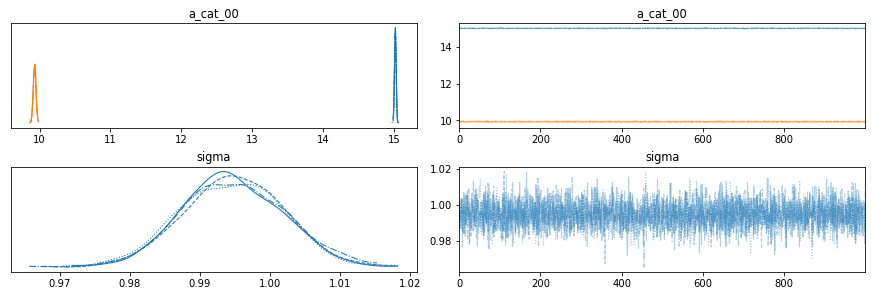

In [20]:
kernel = NUTS(model_00)
mcmc_D_A = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A.run(jax.random.PRNGKey(4), jnp.array(data["A"]), jnp.array(data["D"]))
mcmc_D_A.print_summary()
ds_ = az.from_numpyro(mcmc_D_A)
az.plot_trace(ds_);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1383.33it/s, 3 steps of size 7.69e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]     14.58      0.02     14.58     14.54     14.62   3429.52      1.00
a_cat_00[1]     11.19      0.04     11.19     11.13     11.25   3222.61      1.00
      sigma      1.95      0.01      1.95      1.93      1.98   4865.45      1.00

Number of divergences: 0


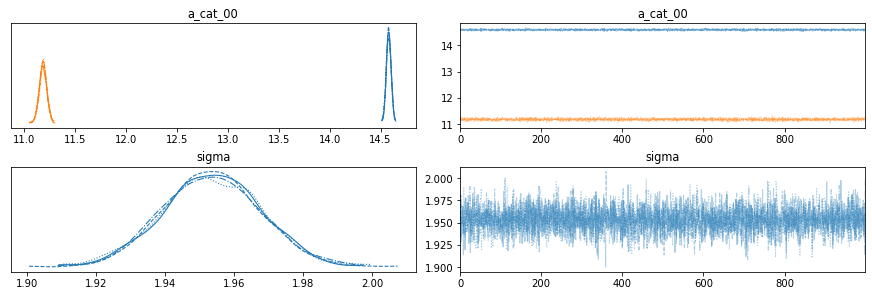

In [21]:
kernel = NUTS(model_00)
mcmc_D_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_M.run(jax.random.PRNGKey(4), jnp.array(data["M"]), jnp.array(data["D"]))
mcmc_D_M.print_summary()
ds_ = az.from_numpyro(mcmc_D_M)
az.plot_trace(ds_);

In [22]:
def model_04(factor_00, factor_01, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, 0.5))
    
    with numpyro.plate("num_data", num_data):
        numpyro.sample("obs", dist.Normal(cell_mean[factor_00, factor_01], sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 923.59it/s, 7 steps of size 7.43e-01. acc. prob=0.89] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cell_mean[0,0]     15.02      0.01     15.02     15.00     15.04   5124.47      1.00
cell_mean[0,1]     14.97      0.04     14.97     14.91     15.03   4314.75      1.00
cell_mean[1,0]      9.82      0.04      9.82      9.75      9.89   4920.61      1.00
cell_mean[1,1]      9.94      0.02      9.94      9.90      9.97   4143.08      1.00
         sigma      0.99      0.01      0.99      0.98      1.01   6381.42      1.00

Number of divergences: 0


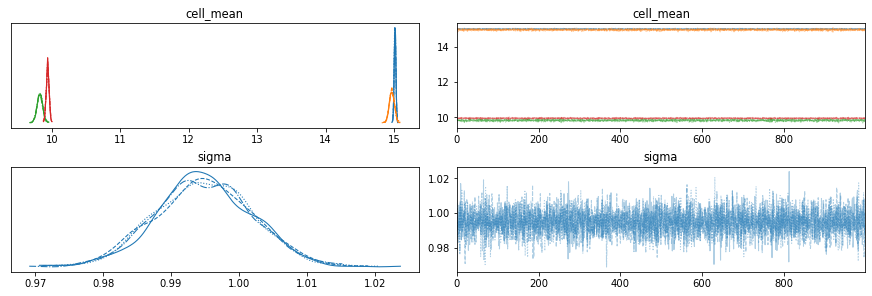

In [56]:
kernel = NUTS(model_04)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(data["A"]),
    jnp.array(data["M"]),
    jnp.array(data["D"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [62]:
mcmc_D_A_M.get_samples()["cell_mean"][0,:]

DeviceArray([[15.031778 , 15.015328 ],
             [ 9.8678465,  9.94701  ]], dtype=float32)

In [63]:
mcmc_D_A_M.get_samples()["cell_mean"][0,:] - mcmc_D_A_M.get_samples()["cell_mean"][0,:].mean()

DeviceArray([[ 2.566287 ,  2.549837 ],
             [-2.5976448, -2.5184813]], dtype=float32)

In [67]:
(mcmc_D_A_M.get_samples()["cell_mean"][0,:] - mcmc_D_A_M.get_samples()["cell_mean"][0,:].mean()).mean(1)

DeviceArray([ 2.558062, -2.558063], dtype=float32)

In [68]:
row_main_effect = np.zeros((4000,2))
col_main_effect = np.zeros((4000,2))
grand_mean = []
for i in range(4000):
    grand_mean_ = mcmc_D_A_M.get_samples()["cell_mean"][i,:].mean()
    row_main_effect[i, :] = (mcmc_D_A_M.get_samples()["cell_mean"][i,:] - grand_mean_).mean(0)
    col_main_effect[i, :] = (mcmc_D_A_M.get_samples()["cell_mean"][i,:] - grand_mean_).mean(1)

In [75]:
col_main_effect.mean(0)

array([ 2.55566882, -2.55566883])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

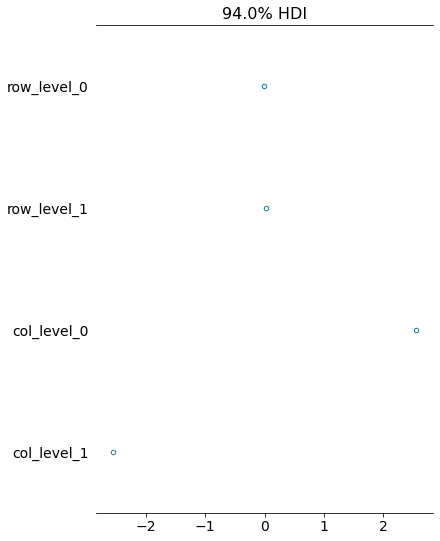

In [73]:
main_effect = {
    "row_level_0": row_main_effect[:, 0],
    "row_level_1": row_main_effect[:, 1],
    "col_level_0": col_main_effect[:, 0],
    "col_level_1": col_main_effect[:, 1],
}
az.plot_forest(main_effect)

In [24]:
post = mcmc_D_A_M.get_samples()
post["diff_diag"] = post["cell_mean"][:, 0, 0] - post["cell_mean"][:, 1, 1]
post["diff_off_diag"] = post["cell_mean"][:, 0, 1] - post["cell_mean"][:, 1, 0]
post["interaction"] = post["cell_mean"][:, 0, 0] - post["cell_mean"][:, 1, 0]
print_summary(post, 0.89, False)


                     mean       std    median      5.5%     94.5%     n_eff     r_hat
 cell_mean[0,0]     15.02      0.01     15.02     15.00     15.04   5115.06      1.00
 cell_mean[0,1]     14.97      0.04     14.97     14.91     15.03   4316.33      1.00
 cell_mean[1,0]      9.82      0.04      9.82      9.76      9.89   4889.68      1.00
 cell_mean[1,1]      9.94      0.02      9.94      9.91      9.97   4117.32      1.00
      diff_diag      5.08      0.02      5.08      5.04      5.12   4187.96      1.00
  diff_off_diag      5.15      0.05      5.15      5.06      5.23   4427.92      1.00
    interaction      5.19      0.04      5.19      5.12      5.25   4956.79      1.00
          sigma      0.99      0.01      0.99      0.98      1.01   6330.14      1.00



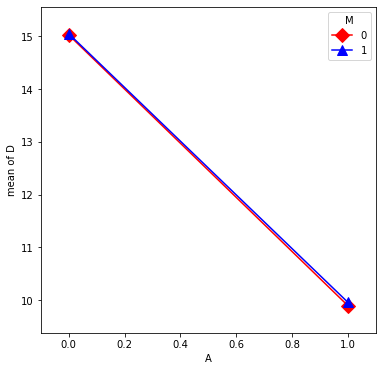

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=data["A"],
    trace=data["M"],
    response=data["D"],
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax,
)

In [38]:
def model_05(X, y=None):
    
    num_data = X.shape[0]
    num_feature = X.shape[1]
    
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    with numpyro.plate("num_feature", num_feature):
        beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    
    with numpyro.plate("num_data", num_data):
        mu = jnp.sum(beta * X, axis=-1)
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [46]:
d = dmatrix("A*M", data)
d

DesignMatrix with shape (10000, 4)
  Intercept  A  M  A:M
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  0    0
          1  0  1    0
  [9970 rows omitted]
  Terms:
    'Intercept' (column 0)
    'A' (column 1)
    'M' (column 2)
    'A:M' (column 3)
  (to view full data, use np.asarray(this_obj))

In [40]:
jnp.array(d)

DeviceArray([[1., 0., 0., 0.],
             [1., 0., 0., 0.],
             [1., 0., 0., 0.],
             ...,
             [1., 0., 0., 0.],
             [1., 0., 0., 0.],
             [1., 0., 0., 0.]], dtype=float32)

sample: 100%|██████████| 1500/1500 [00:02<00:00, 664.66it/s, 15 steps of size 2.36e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     15.01      0.01     15.01     14.99     15.03   3300.59      1.00
   beta[1]     -5.08      0.04     -5.08     -5.16     -5.02   2280.73      1.00
   beta[2]      0.04      0.04      0.04     -0.02      0.10   2627.33      1.00
   beta[3]     -0.01      0.06     -0.01     -0.11      0.08   1843.25      1.00
     sigma      0.99      0.01      0.99      0.98      1.01   4925.62      1.00

Number of divergences: 0


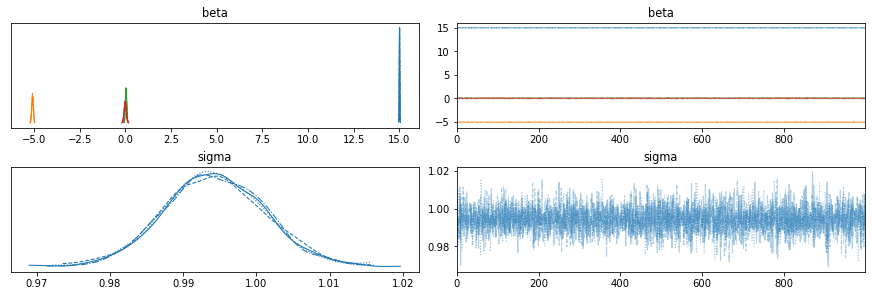

In [41]:
kernel = NUTS(model_05)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(d),
    jnp.array(data["D"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 1968.34it/s, 7 steps of size 6.29e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     15.02      0.01     15.02     15.00     15.04   2507.99      1.00
   beta[1]     -5.07      0.02     -5.07     -5.10     -5.03   2334.46      1.00
     sigma      0.99      0.01      0.99      0.98      1.01   3142.40      1.00

Number of divergences: 0


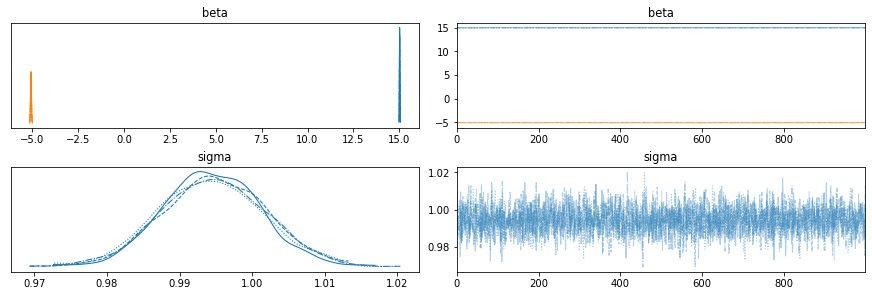

In [44]:
kernel = NUTS(model_05)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(dmatrix("A", data)),
    jnp.array(data["D"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:00<00:00, 1887.93it/s, 7 steps of size 6.83e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     14.57      0.02     14.57     14.53     14.61   2383.72      1.00
   beta[1]     -3.31      0.04     -3.31     -3.38     -3.24   2249.47      1.00
     sigma      1.95      0.01      1.95      1.93      1.97   3232.38      1.00

Number of divergences: 0


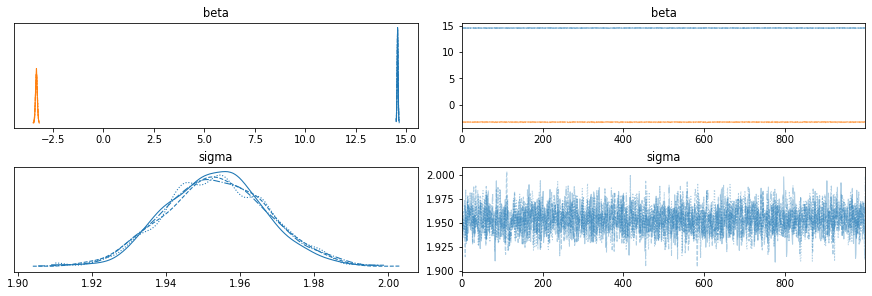

In [45]:
kernel = NUTS(model_05)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(dmatrix("M", data)),
    jnp.array(data["D"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [ ]:
az.plot_forest(
    {
        "m_D~A a[]": mcmc_D_A.get_samples()["a_cat_00"][None, ...],
        "m_D~M a[]": mcmc_D_M.get_samples()["a_cat_00"][None, ...],
        "m_D~A+M - a[]": mcmc_D_A_M.get_samples()["a_cat_00"][None, ...],
        "m_D~A+M - b[]": mcmc_D_A_M.get_samples()["b_cat_01"][None, ...]
    },
    hdi_prob=0.89,
)

In [47]:
def model_01(cat_00, cat_01, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))
    num_cat_01 = len(set(cat_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_01", num_cat_01):
        b_cat_01 = numpyro.sample("b_cat_01", dist.Normal(0, 0.5))

    with numpyro.plate("num_data", num_data):
        mu = a_cat_00[cat_00] + b_cat_01[cat_00]
        #mu = numpyro.deterministic("mu", a_cat_00[cat_00] + b_cat_01[cat_00])
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:24<00:00, 61.25it/s, 91 steps of size 2.49e-02. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
a_cat_00[0]      7.50      0.35      7.50      6.91      8.08   1066.86      1.01
a_cat_00[1]      4.96      0.36      4.96      4.36      5.53   1432.21      1.00
b_cat_01[0]      7.52      0.35      7.52      6.98      8.15   1063.03      1.01
b_cat_01[1]      4.97      0.36      4.98      4.40      5.57   1433.51      1.00
      sigma      0.99      0.01      0.99      0.98      1.01   2322.42      1.00

Number of divergences: 0


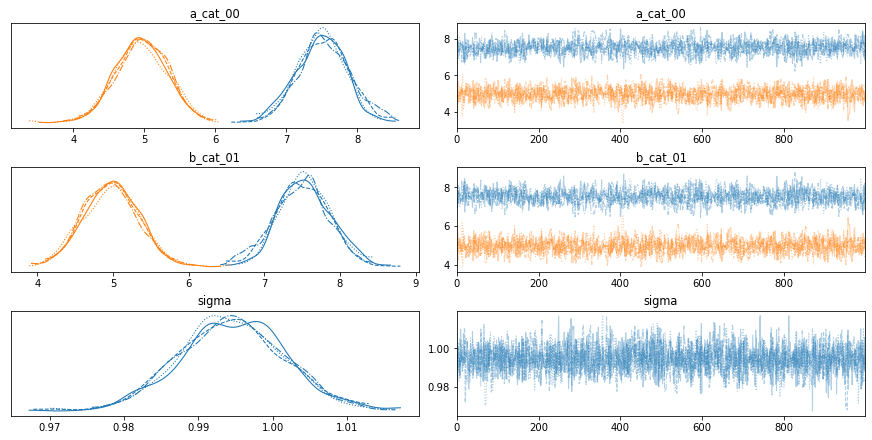

In [48]:
kernel = NUTS(model_01)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(data["A"]),
    jnp.array(data["M"]),
    jnp.array(data["D"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [51]:
mcmc_D_A_M.get_samples().keys()

dict_keys(['a_cat_00', 'b_cat_01', 'sigma'])

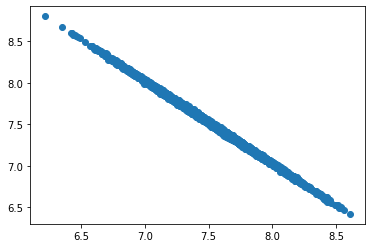

In [52]:
fig, ax = plt.subplots()
ax.scatter(np.array(mcmc_D_A_M.get_samples()["a_cat_00"][:,0]), np.array(mcmc_D_A_M.get_samples()["b_cat_01"][:,0]))

In [ ]:
az.plot_forest(
    {
        "m_D~A a[]": mcmc_D_A.get_samples()["a_cat_00"][None, ...],
        "m_D~M a[]": mcmc_D_M.get_samples()["a_cat_00"][None, ...],
        "m_D~A+M - a[]": mcmc_D_A_M.get_samples()["a_cat_00"][None, ...],
        "m_D~A+M - b[]": mcmc_D_A_M.get_samples()["b_cat_01"][None, ...]
    },
    hdi_prob=0.89,
)

In [ ]:
def model_02(cat_00, cat_01, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))
    num_cat_01 = len(set(cat_01))
    num_interactions = num_cat_00 * num_cat_01

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    grand_mean = numpyro.sample("grand_mean", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_01", num_cat_01):
        b_cat_01 = numpyro.sample("b_cat_01", dist.Normal(0, 0.5))
    

    with numpyro.plate("num_data", num_data):
        mu = grand_mean + a_cat_00[cat_00] + b_cat_01[cat_00]
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [ ]:
kernel = NUTS(model_02)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(data["A"]),
    jnp.array(data["M"]),
    jnp.array((data["D"] - data["D"].mean()) / data["D"].std()),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [ ]:
def model_03(cat_00, cat_01, y=None):
    num_data = cat_00.shape[0]
    num_cat_00 = len(set(cat_00))
    num_cat_01 = len(set(cat_01))
    num_interactions = num_cat_00 * num_cat_01

    sigma = numpyro.sample("sigma", dist.Exponential(1))

    with numpyro.plate("num_cat_00", num_cat_00):
        a_cat_00 = numpyro.sample("a_cat_00", dist.Normal(0, 0.5))

    with numpyro.plate("num_cat_01", num_cat_01):
        b_cat_01 = numpyro.sample("b_cat_01", dist.Normal(0, 0.5))
    

    with numpyro.plate("num_data", num_data):
        mu = a_cat_00[cat_00] + b_cat_01[cat_00] + a_cat_00[cat_00] * b_cat_01[cat_00]
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [ ]:
kernel = NUTS(model_03)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(data["A"]),
    jnp.array(data["M"]),
    jnp.array((data["D"] - data["D"].mean()) / data["D"].std()),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [ ]:
def model_04(factor_00, factor_01, y=None):
    num_data = factor_00.shape[0]
    num_factor_00 = len(set(factor_00))
    num_factor_01 = len(set(factor_01))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    
    with numpyro.plate("num_factor_01", num_factor_01):
        with numpyro.plate("num_factor_00", num_factor_00):
            cell_mean = numpyro.sample("cell_mean", dist.Normal(0, 0.5))
    
    with numpyro.plate("num_data", num_data):
        numpyro.sample("obs", dist.Normal(cell_mean[factor_00, factor_01], sigma), obs=y)

In [ ]:
numpyro.render_model(
    model_04,
    (jnp.array(data["A"]), jnp.array(data["M"]), jnp.array(data["D"])),
    render_distributions=True,
)

In [ ]:
kernel = NUTS(model_04)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(4),
    jnp.array(data["A"]),
    jnp.array(data["M"]),
    jnp.array(data["D"]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [ ]:
data.groupby(["A", "M"]).mean()

In [ ]:
data.groupby(["A"])["D"].mean()

In [ ]:
data.groupby(["M"])["D"].mean()

In [ ]:
proba_ = 0.28
cpt_ = jnp.array([[0.9, 0.1], [0.2, 0.8]])
mean_ = jnp.array([[10.,15.],[15.,10.]])

In [ ]:
def synthetic_01(proba, cpt, mean):
    A = numpyro.sample("A", dist.Bernoulli(proba))
    M = numpyro.sample("M", dist.Categorical(cpt[A]))
    D = numpyro.sample("D", dist.Normal(mean[A, M],1))

In [ ]:
nuts_kernel = NUTS(synthetic_01)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=False)

mcmc = MCMC(
    kernel, num_warmup=500, num_samples=10_000, num_chains=1, jit_model_args=False
)
mcmc.run(
    jax.random.PRNGKey(14),
    proba_,
    cpt_,
    mean_,
)
mcmc.print_summary()
ds_ = az.from_numpyro(mcmc)
az.plot_trace(ds_);

In [ ]:
data = pd.DataFrame(mcmc.get_samples())
sns.pairplot(data)

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
data.groupby(["A", "M"]).mean()

In [ ]:
d = data.sample(frac=1).copy()

In [ ]:
kernel = NUTS(model_04)
mcmc_D_A_M = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
)
mcmc_D_A_M.run(
    jax.random.PRNGKey(42323),
    jnp.array(d["A"][:500]),
    jnp.array(d["M"][:500]),
    jnp.array(d["D"][:500]),
)
mcmc_D_A_M.print_summary(exclude_deterministic=True)
ds_ = az.from_numpyro(mcmc_D_A_M)
az.plot_trace(ds_);

In [ ]:
from numpyro.diagnostics import print_summary

In [ ]:
post = mcmc_D_A_M.get_samples()

In [ ]:
post["diff_diag"] = post["cell_mean"][:, 0, 0] - post["cell_mean"][:, 1, 1]
post["diff_off_diag"] = post["cell_mean"][:, 0, 1] - post["cell_mean"][:, 1, 0]
post["interaction"] = post["cell_mean"][:, 0, 0] - post["cell_mean"][:, 1, 0]
print_summary(post, 0.89, False)

In [ ]:
az.plot_forest(
    {
        "diff_diag": post["diff_diag"][None, ...],
        "diff_off_diag": post["diff_off_diag"][None, ...],
        "interaction": post["interaction"][None, ...],
    },
    hdi_prob=0.89,
)

In [ ]:
data

In [ ]:
from statsmodels.graphics.factorplots import interaction_plot

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=data["A"],
    trace=data["M"],
    response=data["D"],
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax,
)

In [ ]:
sns.boxplot(x="A", y="D", hue="M", data=data)

In [ ]:
post["cell_mean"].mean(0)

In [ ]:
data.groupby(["A","M"]).mean()

In [ ]:
data.groupby(["A","M"]).mean().values.reshape(2,2)

In [ ]:
post["cell_mean"].mean(0).mean()

In [ ]:
d.mean()

In [ ]:
d["D"][:500].mean()

In [ ]:
d.iloc[:100].groupby(["A","M"]).mean().values.reshape(2,2).mean()

In [ ]:
d.iloc[:1000]["D"].mean()